In [1]:

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets list

ref                                                                   title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
asinow/car-price-dataset                                              Car Price Dataset                                 135KB  2025-01-26 19:53:28          18919        306  1.0              
asinow/diabetes-dataset                                               Diabetes Dataset                                  224KB  2025-02-20 08:38:56           1231         28  1.0              
mahmoudelhemaly/students-grading-dataset                              Student Performance & Behavior Dataset            508KB  2025-02-17 17:38:46           2618         45  1.0              
adilshamim8/student-performance-and-lear

In [4]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Kaggle API - Download dataset
!kaggle datasets download -d mohammedabdeldayem/the-fake-or-real-dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/mohammedabdeldayem/the-fake-or-real-dataset
License(s): GNU Lesser General Public License 3.0
100% 16.0G/16.0G [12:04<00:00, 24.1MB/s]
100% 16.0G/16.0G [12:04<00:00, 23.8MB/s]


In [5]:
def load_audio_from_folders(base_path, visualize_samples=5):
    features, labels = [], []
    categories = {"real": 0, "fake": 1}
    count = 0

    for label, class_id in categories.items():
        folder_path = os.path.join(base_path, label)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                # Load audio file
                audio, sr = librosa.load(file_path, sr=16000)
                mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                # Visualize only a few samples
                if count < visualize_samples:
                    plt.figure(figsize=(10, 4))
                    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
                    plt.colorbar(format='%+2.0f dB')
                    plt.title(f'Mel Spectrogram - {label.upper()} - {file_name}')
                    plt.show()
                    count += 1

                features.append(mel_spec_db)
                labels.append(class_id)

            except Exception as e:
                print(f"Error loading {file_name}: {e}")

    return np.array(features), np.array(labels)


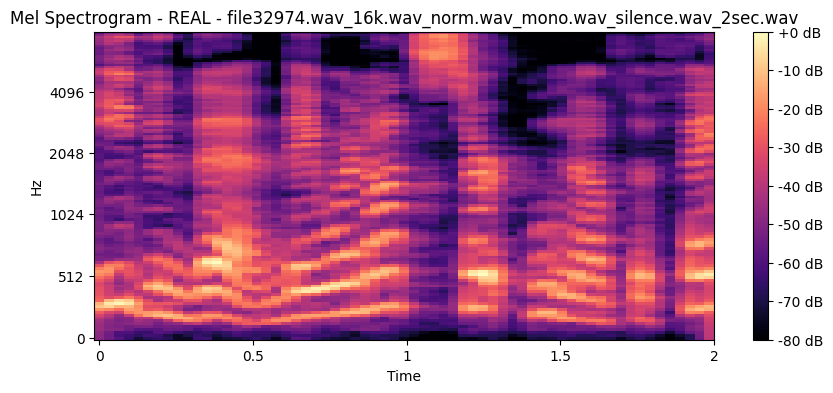

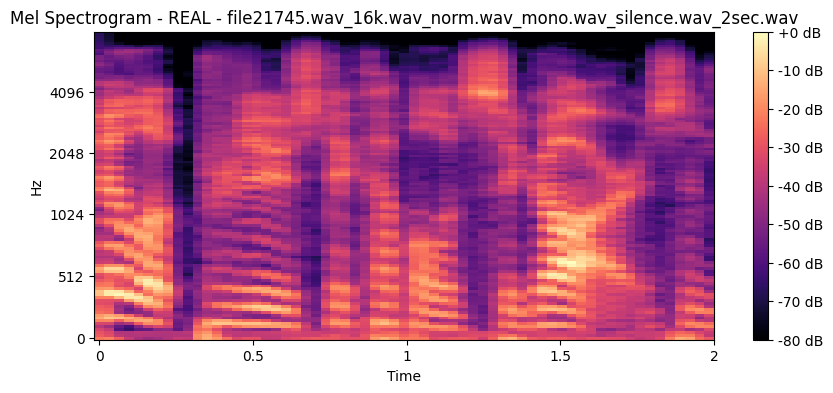

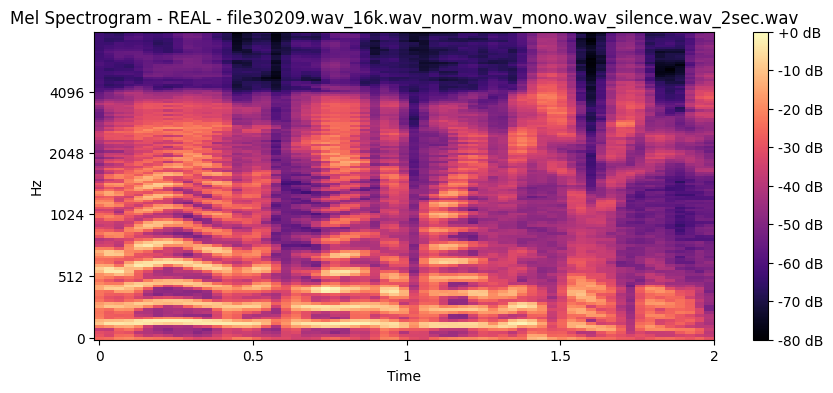

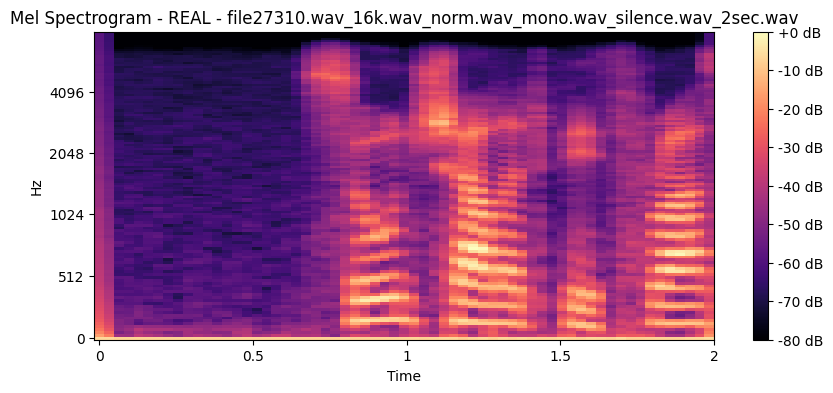

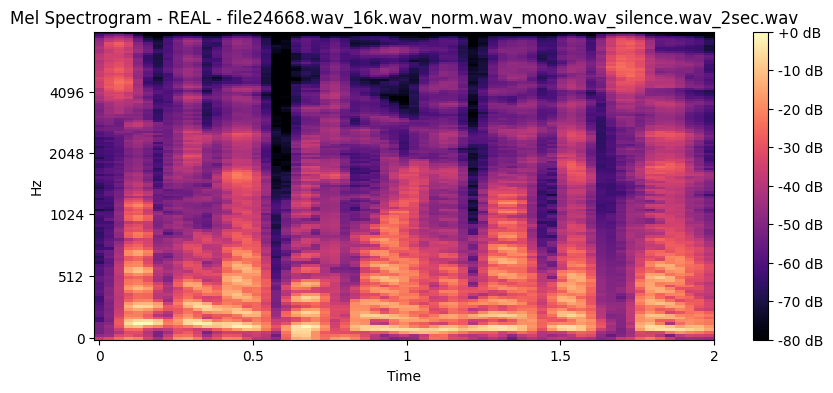

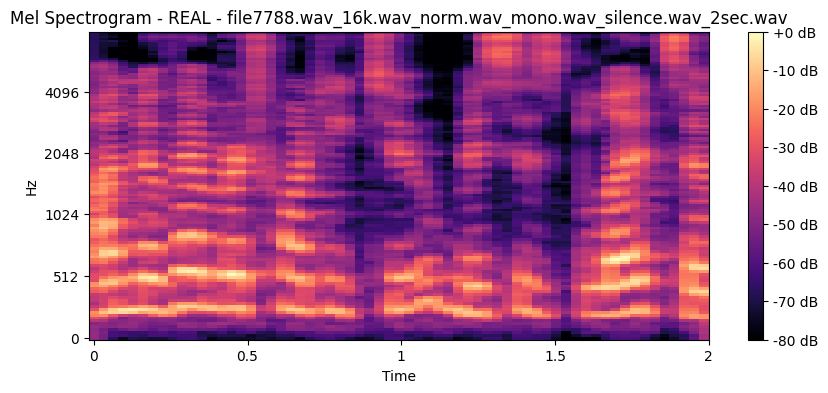

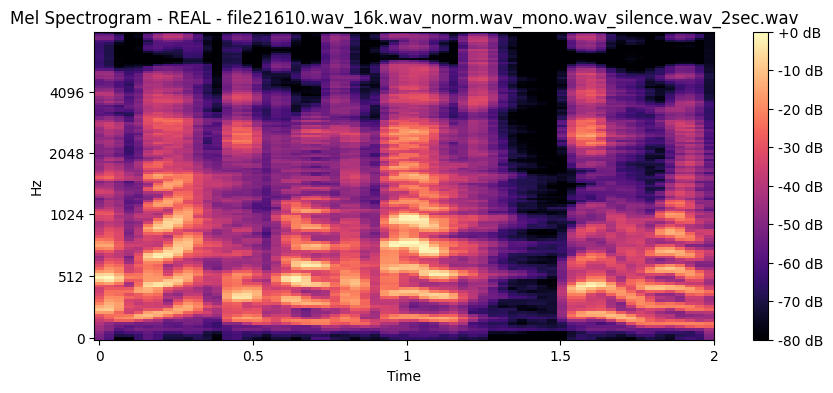

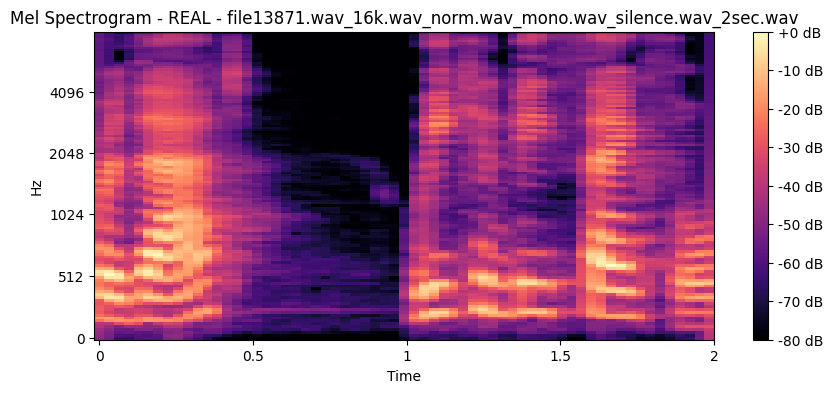

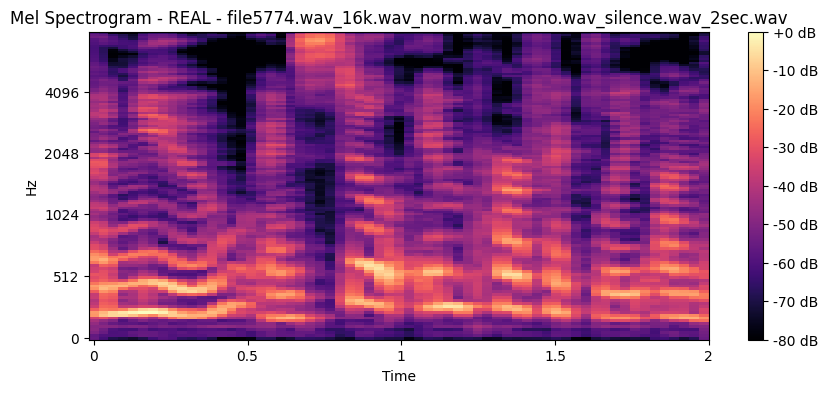

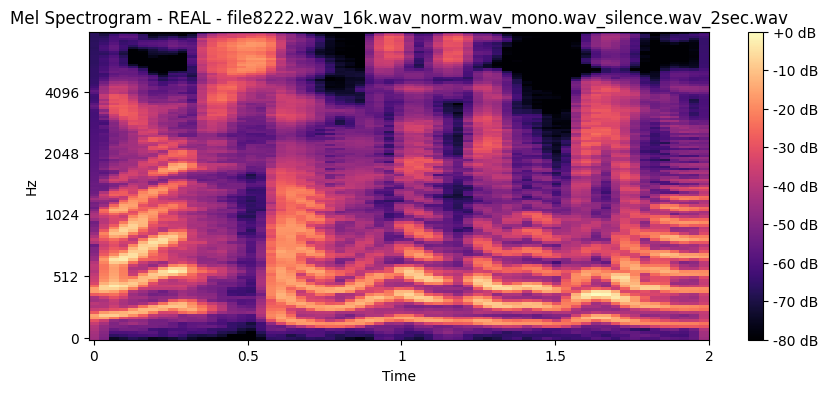

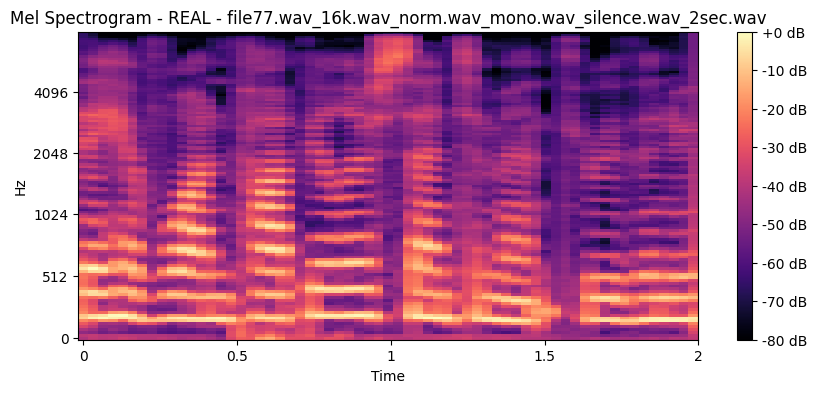

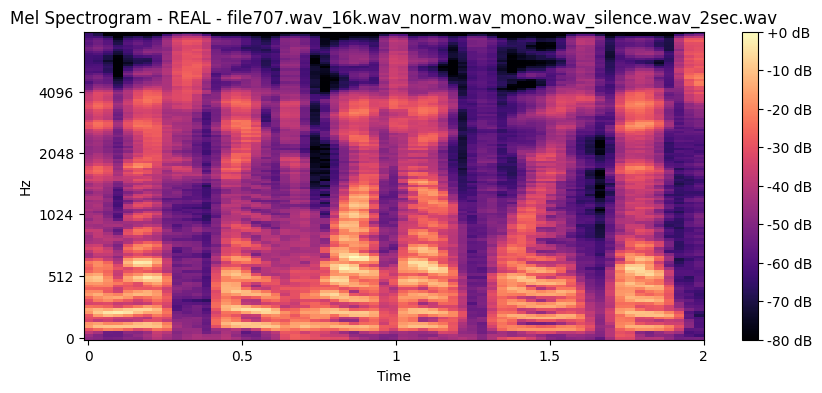

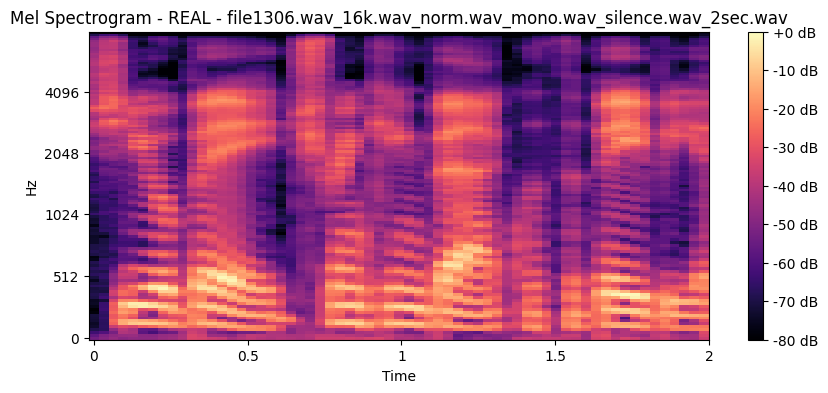

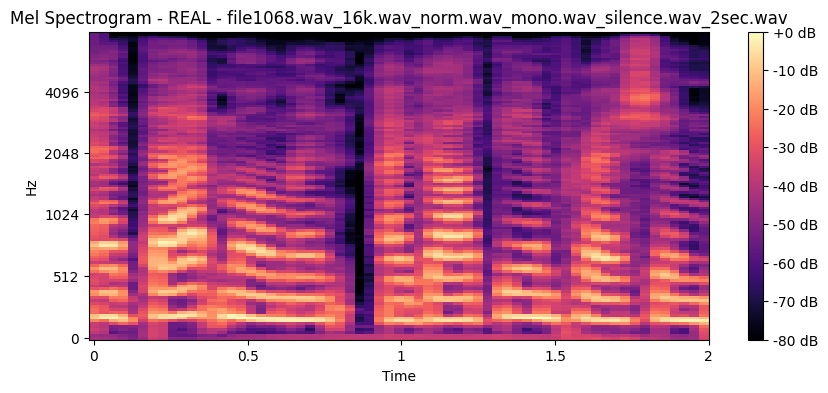

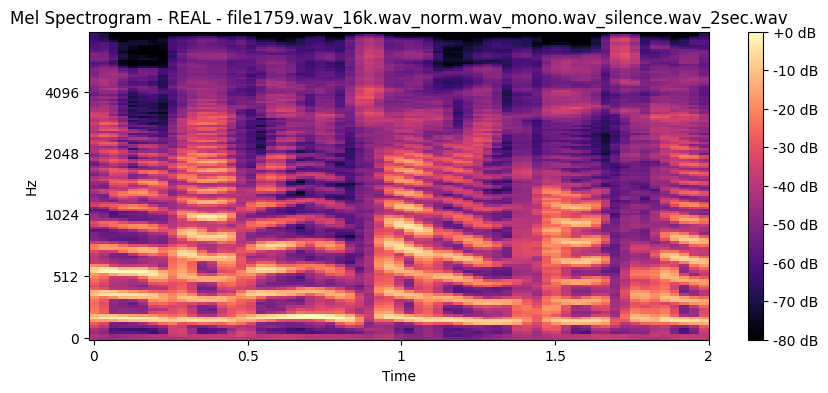

Train shape: (13956, 128, 63, 1), Validation shape: (2826, 128, 63, 1), Test shape: (1088, 128, 63, 1)


In [6]:
# Define dataset paths
TRAIN_PATH = "/content/for-2sec/for-2seconds/training"
VALID_PATH = "/content/for-2sec/for-2seconds/validation"
TEST_PATH = "/content/for-2sec/for-2seconds/testing"

# Load data
X_train, y_train = load_audio_from_folders(TRAIN_PATH)
X_valid, y_valid = load_audio_from_folders(VALID_PATH)
X_test, y_test = load_audio_from_folders(TEST_PATH)

# Reshape for CNN input
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Convert labels to categorical
y_train = to_categorical(y_train, 2)
y_valid = to_categorical(y_valid, 2)
y_test = to_categorical(y_test, 2)

print(f"Train shape: {X_train.shape}, Validation shape: {X_valid.shape}, Test shape: {X_test.shape}")


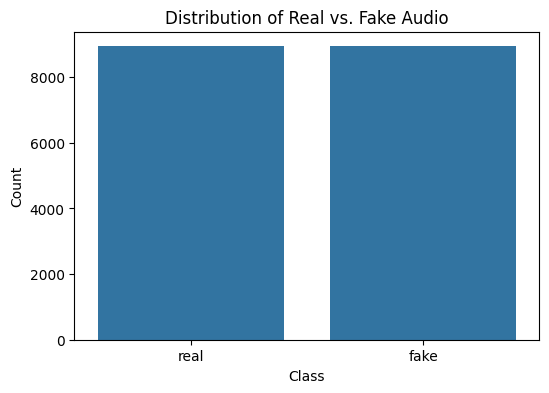

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x=["real" if y == 0 else "fake" for y in np.concatenate((np.argmax(y_train, axis=1),
                                                                      np.argmax(y_valid, axis=1),
                                                                      np.argmax(y_test, axis=1)))])
plt.title("Distribution of Real vs. Fake Audio")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [8]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')  # Binary classification (real vs. fake)
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 61, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 6, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,376,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,469,314 (5.60 MB)

 Trainable params: 1,469,314 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=32)


Epoch 1/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9844 - loss: 0.0439 - val_accuracy: 0.9710 - val_loss: 0.0983
Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9820 - loss: 0.0466 - val_accuracy: 0.9781 - val_loss: 0.0589
Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9898 - loss: 0.0307 - val_accuracy: 0.9869 - val_loss: 0.0398
Epoch 4/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9911 - loss: 0.0261 - val_accuracy: 0.9604 - val_loss: 0.1205
Epoch 5/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9879 - loss: 0.0363 - val_accuracy: 0.9901 - val_loss: 0.0443
Epoch 6/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9937 - loss: 0.0162 - val_accuracy: 0.9855 - val_loss: 0.0492
Epoch 7/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9969 - loss: 0.0109 - val_accuracy: 0.9883 - val_loss: 0.0363
Epoch 8/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9918 - loss: 0.0224 - val_accuracy: 0.

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8373 - loss: 1.3979
Test Accuracy: 53.77%


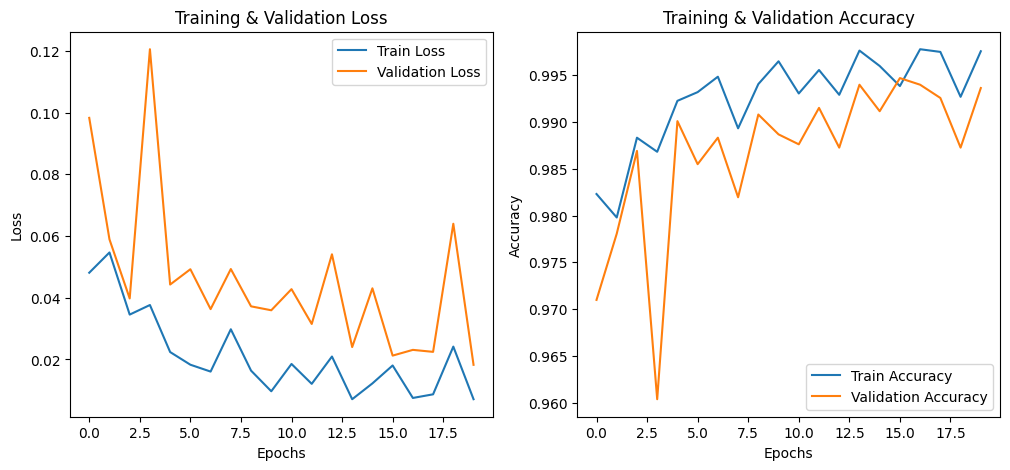

In [12]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


In [15]:
predictions = model.predict(X_valid)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Show random predictions
for i in range(5):
    print(f"Actual: {'Real' if true_labels[i] == 0 else 'Fake'}, Predicted: {'Real' if predicted_labels[i] == 0 else 'Fake'}")


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Actual: Real, Predicted: Real
Actual: Real, Predicted: Real
Actual: Real, Predicted: Real
Actual: Real, Predicted: Real
Actual: Real, Predicted: Real


In [16]:
# Save the entire model
model.save("ai_audio_detector.h5")

print("Model saved successfully!")


Model saved successfully!
